# Setup of Imports, Units and Parameters

In [1]:
import ipynb
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import scipy.constants as consts
import lmfit
from pylcp.common import progressBar
import ast
import csv
import pickle
from scipy.optimize import bisect
from tqdm import tqdm
from ipynb.fs.full.MagnetsInterpolation import ComsolMagCylindricalInterpolation_au as mi
import inspect

loadpath = "./csv/"
savepath = "./images/"

# Parameters and units

In [2]:
import matplotlib as mpl

rcparams = {
# 'axes.titlesize'    : 18,
# 'axes.labelsize'    : 16,
# 'xtick.labelsize'   : 12,
# 'ytick.labelsize'   : 12,
# 'legend.fontsize'   : 12,
'font.size'         : 20
}
for e in rcparams.keys():
    mpl.rcParams[e] = rcparams[e]

# Unit conversion factors
k = 4369238.4 # m^-1
Gamma = 95.9e6 # MHz | Lurio and Novick
mu_B = consts.value('Bohr magneton') # JT^-1 = m^2A
h = consts.h # Js = kgm^2s^-1
hbar = consts.hbar # Js = kgm^2s^-1

Bgrad = np.sqrt(Gamma*k)

# Base units
time_unit = 1/Gamma # s
length_unit = 1/k # m
# length_unit = hbar*Gamma/(mu_B*Bgrad)
# time_unit = length_unit*k/Gamma
# length_unit = 1e-2
# length_unit = 1
mass_unit = h*time_unit/(length_unit**2) # kg
# mass_unit = 1
current_unit = mu_B/(length_unit**2) # A

# Some useful compund units
force_unit = mass_unit*length_unit/(time_unit**2) # N
velocity_unit = length_unit/time_unit # m/s
energy_unit = mass_unit*(length_unit**2)/(time_unit**2) # J
power_unit = energy_unit/time_unit # W
intensity_unit = power_unit/(length_unit**2) # W/m^2
intensity_unit_cm = intensity_unit/(100**2) # W/cm^2
tesla_unit = mass_unit/(current_unit*time_unit**2)
gauss_unit = 10000*tesla_unit
cm_unit = length_unit*100
hertz_unit = 1/time_unit
amu_unit = mass_unit/1.66054e-27

# gauss_to_gamma = hbar*Gamma/(10**(-4)*mu_B)

In [3]:
# laser parameters from Simon
slower_beam_width = 0.5/cm_unit
slower_I = 0.3/intensity_unit_cm
slower_detuning = 0 # Placeholder
MOT_detuning = -1.45*100e6/hertz_unit
MOT_s = 2
MOT_beam_width = 0.4/cm_unit
Isat = 1.1/intensity_unit_cm
slower_s = slower_I/Isat

# Some parameters for the MOT
# Mass taken from IAEA
mass = {106 : 105.9064598/amu_unit, 108 : 107.9041836/amu_unit, 110 : 109.9030075/amu_unit, 111 : 110.9041838/amu_unit, 112 : 111.90276390/amu_unit, 113 : 112.90440811/amu_unit, 114 : 113.90336500/amu_unit, 116 : 115.90476323/amu_unit}
abundance_data = {106 : 0.0125, 108 : 0.0089, 110 : 0.1249, 111 : 0.1280, 112 : 0.2413, 113 : 0.1222, 114 : 0.2873, 116 : 0.0749}
isotope_shift_zero = 114
Z = 48

# Take isotope shift data from here: https://arxiv.org/pdf/2210.11425.pdf [Table II, this work]
isotope_shifts = {106 : 1818.1e6/hertz_unit, 108 : 1336.5e6/hertz_unit, 110 : 865e6/hertz_unit, 111 : 805.0e6/hertz_unit, 112 : 407.5e6/hertz_unit, 113 : 344.9e6/hertz_unit, 114 : 0/hertz_unit, 116 : -316.1e6/hertz_unit}
isotope_shift_hyperfine = {111 : (899.2e6 - 616.5e6)/hertz_unit, 113 : (443.4e6 - 147.8e6)/hertz_unit}

In [4]:
print(mass)
print(1.866628e-25/mass_unit)
print(mass_unit)
print(hbar/(mass_unit*length_unit**2/time_unit))
print(isotope_shifts)
print(velocity_unit)
print(amu_unit)
print(mass_unit/amu_unit - 1.66054e-27)
print(gauss_unit)

{106: 1333.2846722717732, 108: 1358.4345500696195, 110: 1383.5982773198102, 111: 1396.2023528176844, 112: 1408.773744061239, 113: 1421.3837102029154, 114: 1433.9598449562861, 116: 1459.1559811335326}
1415.1708361560925
1.3190124840829548e-28
0.15915494309189535
{106: 18.958289885297184, 108: 13.936392075078206, 110: 9.019812304483837, 111: 8.394160583941606, 112: 4.249217935349322, 113: 3.596454640250261, 114: 0.0, 116: -3.2961418143899897}
21.94890532867238
0.07943274381122736
0.0
68.51837792066333


# Hamiltonians, magnetic fields and laser field generating functions

## Hamiltonians

In [5]:
# Hamiltonians
ham_det = 0

def gen_Boson_Hamiltonian(isotope = 114):
    Hg, Bgq = pylcp.hamiltonians.singleF(F=0, gF=0, muB=1)
    He, Beq = pylcp.hamiltonians.singleF(F=1, gF=1, muB=1)
    dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)
    return pylcp.hamiltonian(Hg, He + (isotope_shifts[isotope] - ham_det)*np.eye(3), Bgq, Beq, dijq,mass=mass[isotope],k=k*length_unit, gamma = Gamma*time_unit)

def gen_Fermion_Hamiltonian(isotope = 111):
    #Hamiltonian for F=1/2 -> F = 1/2,3/2 
    HgFermion, BgqFermion = pylcp.hamiltonians.hyperfine_coupled(J=0, I=1/2, gJ=0, gI=0, Ahfs=0, Bhfs=0, Chfs=0, muB=1)
    # HeFermion, BeqFermion = pylcp.hamiltonians.hyperfine_coupled(J=1, I=1/2, gJ=1, gI=0, Ahfs=2.2, Bhfs=0, Chfs=0, muB=1)
    Ahfs = 2*isotope_shift_hyperfine[isotope]/3
    HeFermion, BeqFermion = pylcp.hamiltonians.hyperfine_coupled(J=1, I=1/2, gJ=1, gI=0, Ahfs=Ahfs, Bhfs=0, Chfs=0, muB=1)
    dijqFermion = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(J=0, Jp=1, I=0.5)
    return pylcp.hamiltonian(HgFermion, HeFermion + (isotope_shifts[isotope] - ham_det)*np.eye(6), BgqFermion, BeqFermion, dijqFermion,mass=mass[isotope],k=k*length_unit, gamma = Gamma*time_unit)

Hamiltonians = {}
# Generate all Hamiltonians
for key in mass.keys():
    if (key in isotope_shift_hyperfine.keys()):
        Hamiltonians[key] = gen_Fermion_Hamiltonian(key)
        continue
    Hamiltonians[key] = gen_Boson_Hamiltonian(key)

## Magnets

In [6]:
permMagnets=mi('./csv/2D_Br.csv', './csv/2D_Bz.csv', gammaMHz=Gamma, symmetry = -1, gauss_unit=gauss_unit, cm_unit = cm_unit)
permMagnetsPylcp = pylcp.magField(permMagnets.fieldCartesian)

## Check magnetic fields

H:\Cd-MOT\MagnetsInterpolation.ipynb:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "        self.bAxdata = np.array([[float(i) for i in row] for row in strData[9:]])\n",


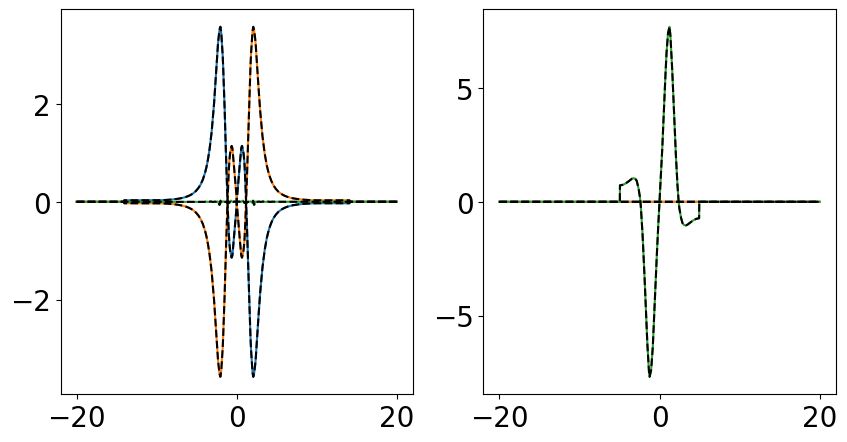

In [7]:
#Now if I make the radial and axial plots, they should still look as expected. Along the line y=-x, By =-Bx by symmetry.
posns = np.arange(-20.0/cm_unit,20.0/cm_unit,0.02/cm_unit)
fig, ax = plt.subplots(1,2,figsize=[10,5])
ax[0].plot(posns*cm_unit,np.array([permMagnets.fieldCartesian(np.array([-i/np.sqrt(2),i/np.sqrt(2),0]),0) for i in posns]))
ax[1].plot(posns*cm_unit,np.array([permMagnets.fieldCartesian(np.array([0.0,0.0,i]),0) for i in posns]))

#checking that the pylcp still gets the same field profiles
ax[0].plot(posns*cm_unit,np.array([permMagnetsPylcp.Field(np.array([-i/np.sqrt(2),i/np.sqrt(2),0]),0) for i in posns]), 'k--')
ax[1].plot(posns*cm_unit,np.array([permMagnetsPylcp.Field(np.array([0.0,0.0,i]),0) for i in posns]), 'k--')

## Laser fields

In [8]:
def MOT_and_Slow_Beams(det_MOT, det_slower):
    return pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([-1, 0., 0.]), 'pol':-1, 'delta':0*slower_detuning + det_slower, 's':slower_s,'wb':slower_beam_width}
    ], beam_type=pylcp.gaussianBeam)

def MOT_Beams(det_MOT, *args):
    return pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width}
    ], beam_type=pylcp.gaussianBeam)

def MOT_Beams_infinite(det_MOT, *args):
    return pylcp.laserBeams([
        {'kvec':np.array([1., 0., 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s},#,'wb':MOT_beam_width},
        {'kvec':np.array([-1., 0., 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s},#,'wb':MOT_beam_width},
        {'kvec':np.array([0., 1., 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s},#,'wb':MOT_beam_width},
        {'kvec':np.array([0., -1., 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s},#,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s},#,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s},#,'wb':MOT_beam_width}
    ], beam_type=pylcp.infinitePlaneWaveBeam)

# Capture velocity simulations

## Wrapper functions

In [142]:
def captured_condition(t, y):
    # ret = ((y[-6]*velocity_unit)**2 + (y[-3]*length_unit)**2) - 1e-2
    # units = [length_unit,length_unit,length_unit,velocity_unit,velocity_unit,velocity_unit]
    # ret = sum ([(x*unit)**2 for x, unit in zip(y[-6:], units)]) - 1e-2
    # if ret < 0:
        # print(y[-3], y[-6])
    #     print(ret)
    return ((y[-6]*velocity_unit)**2 + (y[-3]*length_unit)**2) - 1e-2

def lost_condition(t, y):
    return y[-3]-2/cm_unit

def backwards_lost(t, y):
    return y[-3] + 12/cm_unit

captured_condition.terminal = True
lost_condition.terminal = True
backwards_lost.terminal = True

def captureVelocityForEq(det_MOT, det_slower, ham, lasers = MOT_and_Slow_Beams):
    print (f"{det_MOT*hertz_unit/1e6:.2f} {det_slower*hertz_unit/1e6:.2f}", end = '                                                                            \r')
    eq = pylcp.rateeq(lasers(det_MOT, det_slower),permMagnetsPylcp, ham,include_mag_forces=False)
    try:
        eq.set_initial_pop(np.array([1., 0., 0., 0.]))
    except ValueError: # Quick and dirty solution to detect the two fermionic hamiltonians
        eq.set_initial_pop(np.array([1., 0., 0., 0., 0., 0., 0., 0.]))
    return findCaptureVelocity(np.array([-8/cm_unit,0,0]), eq)
    

def isCaptured(sol):
    captured = -1
    # finalPosition = np.array([sol.r[i][-1] for i in range(3)])
    # finalVelocity = np.array([sol.v[i][-1] for i in range(3)])
    finalPosition = np.array([sol.r[i][-1] for i in range(1)])
    finalVelocity = np.array([sol.v[i][-1] for i in range(1)])
    # print (np.linalg.norm(finalPosition*length_unit)**2 + np.linalg.norm(finalVelocity*velocity_unit)**2)
    # print (finalPosition,finalVelocity)
    # print (sol.r[:,-1], sol.v[:,-1])
    # print (finalPosition*length_unit,finalVelocity*velocity_unit)
    if (np.linalg.norm(finalPosition*length_unit)**2 + np.linalg.norm(finalVelocity*velocity_unit)**2 <1.2e-2):
        #print('initial velocity: '+ str(sol.v[0][0]) +' captured')
        captured = 1 
    return captured

def atomTrajectoryToMOT(v0, r0, eqn, tmax=10, max_step=1, **kwargs):
    eqn.set_initial_position_and_velocity(r0, np.array([v0,0,0]))
    eqn.evolve_motion([0., 1e-1/time_unit], events=[captured_condition,lost_condition,backwards_lost],method = "BDF")

    return isCaptured(eqn.sol)

def findCaptureVelocity(r0,eqn):
    if(atomTrajectoryToMOT(40/velocity_unit, r0, eqn, tmax=10, max_step=1)==-1):
        return 0
    return bisect(atomTrajectoryToMOT,40/velocity_unit, 400/velocity_unit,
       args=(r0, eqn),
       xtol=1e-3, rtol=1e-3, full_output=False)

# Force curves

In [127]:
assert abs(Gamma/k - velocity_unit)/velocity_unit < 1e-2
print(velocity_unit)
print(Gamma/k)

21.94890532867238
21.94890532867238


In [128]:
rateeq = pylcp.rateeq(MOT_and_Slow_Beams(MOT_detuning,-10*Gamma/hertz_unit), permMagnetsPylcp, gen_Boson_Hamiltonian() ,include_mag_forces=False)

In [129]:
r = np.linspace(-10/cm_unit, 10/cm_unit, 200)
v = np.linspace(-300/velocity_unit, 300/velocity_unit, 200)

R, V = np.meshgrid(r, v)
rateeq.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True)

Completed in 26.38 s.                                               


In [130]:
rateeq.set_initial_position_and_velocity(np.array([-8/cm_unit, 0., 0.]),np.array([20/velocity_unit, 0., 0.]))
rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
rateeq.evolve_motion([0., 1/time_unit], events=[captured_condition, lost_condition, backwards_lost], progress_bar=True, method= 'BDF')
sol = rateeq.sol

Completed in 0.78 s.                                                  


(-300.0, 300.0)

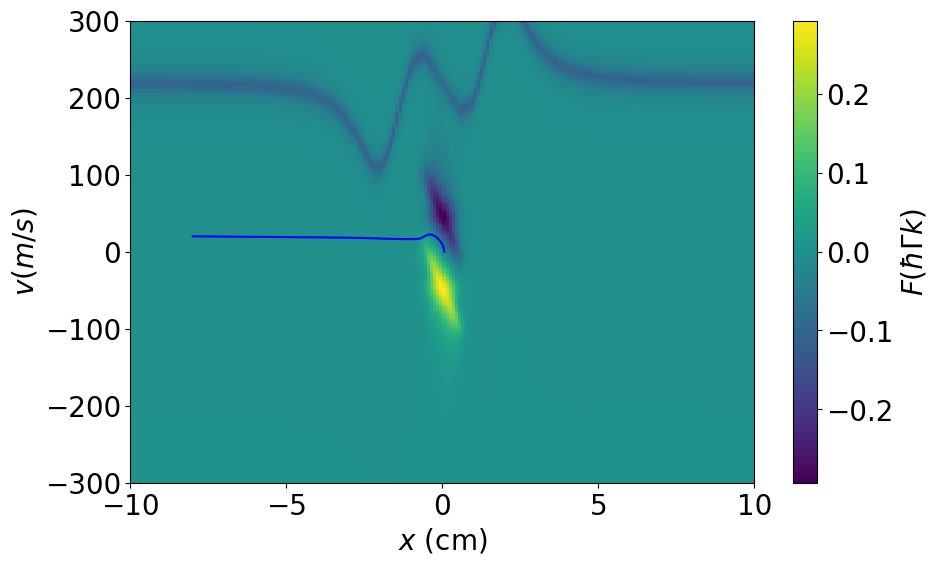

In [131]:
fig, ax = plt.subplots(1, 1,figsize=[10,6])
ax.plot(sol.r[0]*cm_unit,sol.v[0]*velocity_unit,'b-')
colormesh = ax.pcolormesh(R*cm_unit, V*velocity_unit, rateeq.profile['Frad'].F[0], cmap = 'viridis')
cb1 = plt.colorbar(colormesh)
cb1.set_label('$F(\\hbar\\Gamma k)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v(m/s)$')
fig.subplots_adjust(left=0.12,right=0.9)
ax.set_xlim([-10,10])
ax.set_ylim([-300,300])

In [144]:
captureVelocityForEq(MOT_detuning, -10*Gamma/hertz_unit, Hamiltonians[114])*velocity_unit

86.142578125

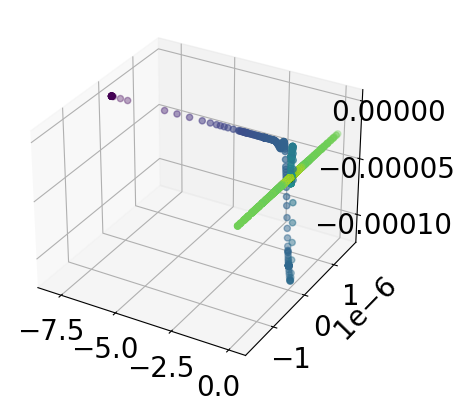

In [33]:
%matplotlib inline
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(sol.r[0]*cm_unit, sol.r[1]*cm_unit, sol.r[2]*cm_unit, c = sol.t)

In [34]:
fig.savefig("images/3Dcapture.png")

## Run for capture vels

In [146]:
MOT_range = np.linspace(MOT_detuning - 200e6/hertz_unit, MOT_detuning + 200e6/hertz_unit,41)
slower_range = np.linspace(-1000e6/hertz_unit, -400e6/hertz_unit,41)

In [ ]:
capture_data = {}

for i, shift in isotope_shifts.items():
    if (i!=114):
        continue
    print (f"\n{i}:")
    capture_data[i] =  [[captureVelocityForEq(dMOT, dSlow, Hamiltonians[i]) for dMOT in MOT_range] for dSlow in slower_range]


114:


In [ ]:
to_be_plotted = None

for i, cap_data in capture_data.items():
    if to_be_plotted is None:
        to_be_plotted = abundance_data[i]*0 + np.array(cap_data)
        continue
    to_be_plotted += abundance_data[i]*0 + np.array(cap_data)
    

plt.pcolormesh(*np.meshgrid(MOT_range*hertz_unit/1e9, slower_range*hertz_unit/1e9), to_be_plotted*velocity_unit, cmap = 'gnuplot')
plt.colorbar()